In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv("/content/traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

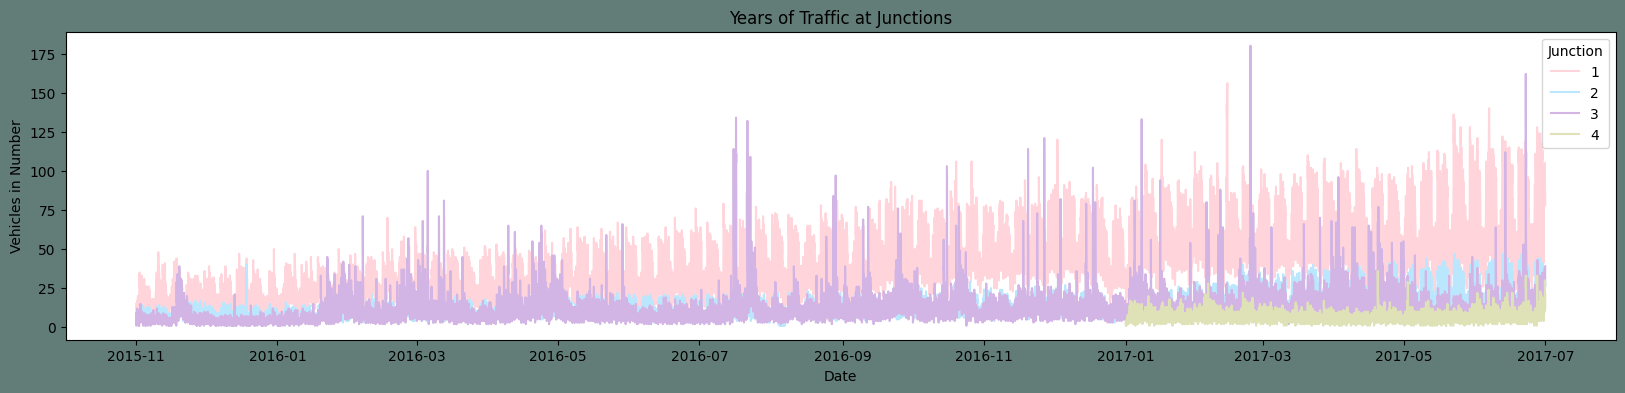

In [5]:
# dataframe to be used for EDA
dataframe=dataset.copy()

# Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)
Time_series.set_title("Years of Traffic at Junctions")
Time_series.set_ylabel("Vehicles in Number")
Time_series.set_xlabel("Date")

In [6]:
# Exploring more features
dataframe["Year"]= dataframe['DateTime'].dt.year
dataframe["Month"]= dataframe['DateTime'].dt.month
dataframe["Date_no"]= dataframe['DateTime'].dt.day
dataframe["Hour"]= dataframe['DateTime'].dt.hour
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")
dataframe.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


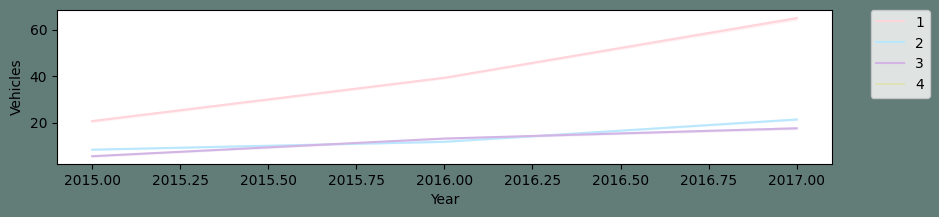

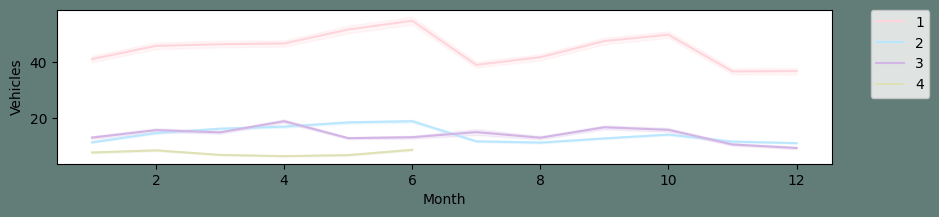

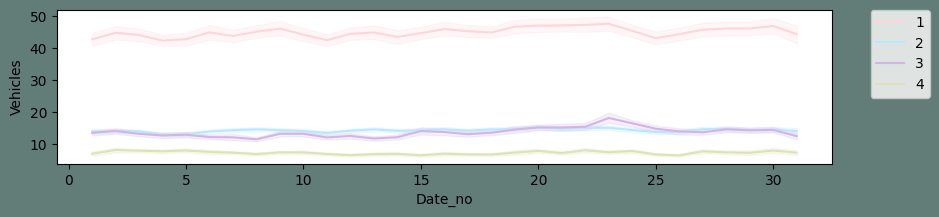

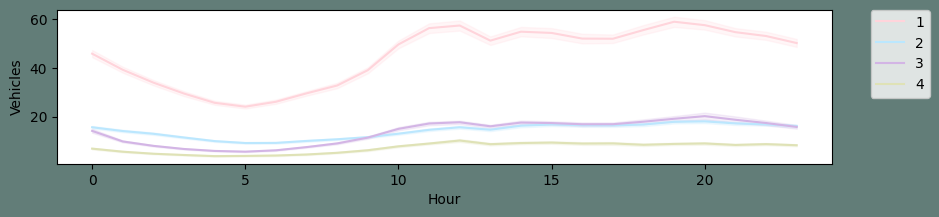

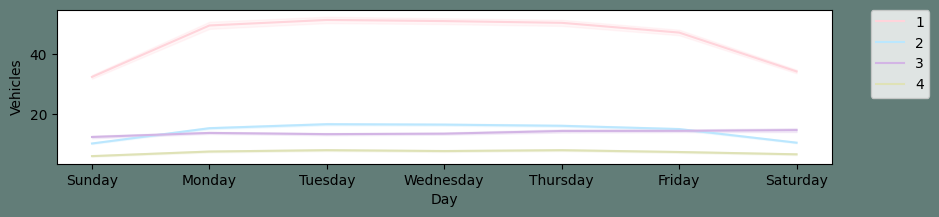

In [7]:
# Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

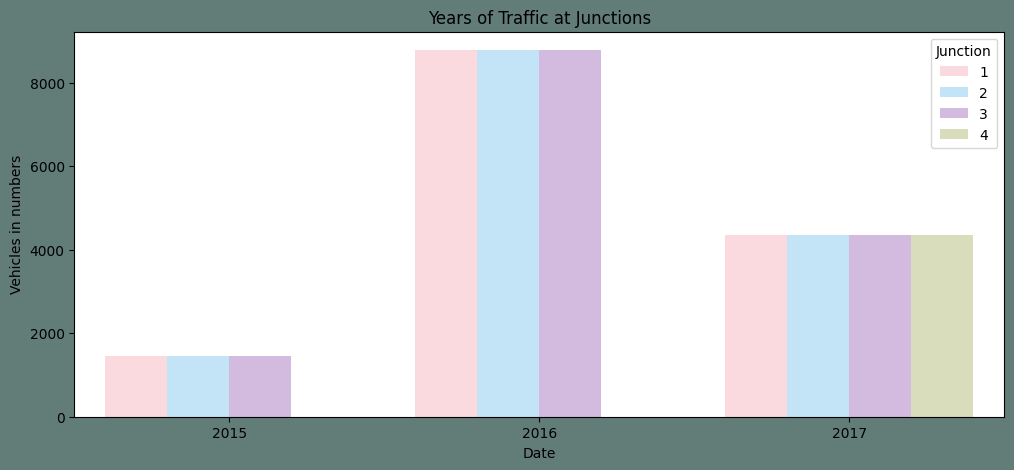

In [16]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)
count.set_title("Years of Traffic at Junctions")
count.set_ylabel("Vehicles in numbers")
count.set_xlabel("Date")

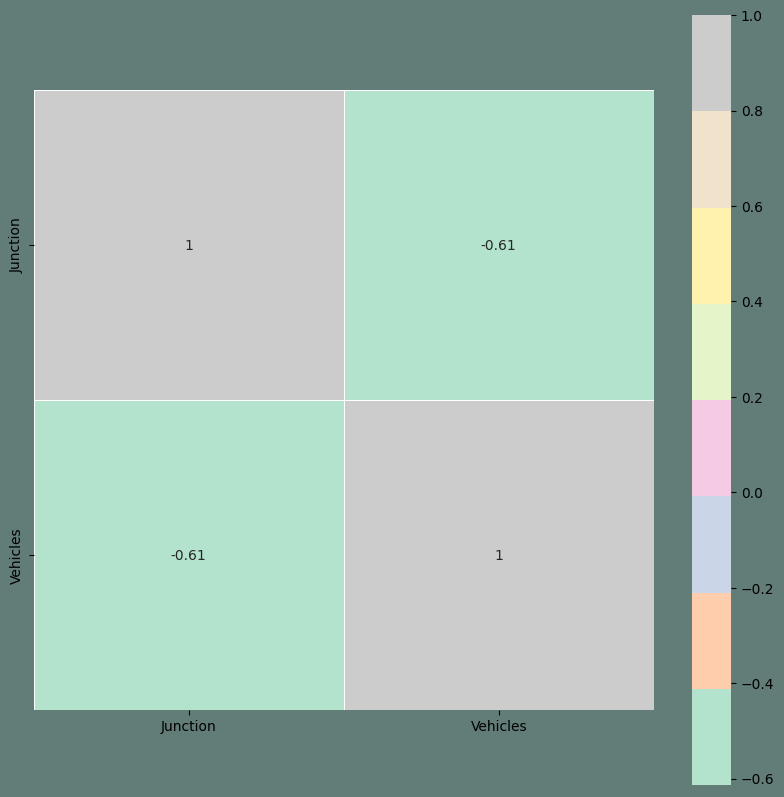

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = dataframe.select_dtypes(include=['float64', 'int64'])  # Ensure 'df' is your DataFrame

# Compute the correlation matrix using only numeric columns
corrmat = numeric_df.corr()

# Set up the figure
plt.figure(figsize=(10, 10), facecolor="#627D78")

# Create the heatmap
sns.heatmap(corrmat, cmap="Pastel2", annot=True, square=True, linewidths=0.5)

# Show the plot
plt.show()


In [9]:
sns.pairplot(data=dataframe, hue= "Junction",palette=colors)

Error in callback <function _draw_all_if_interactive at 0x7ed13946a830> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ed139469ab0> (for post_execute):


KeyboardInterrupt: 

In [10]:
# Pivoting dataset from junction
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")
dataframe_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

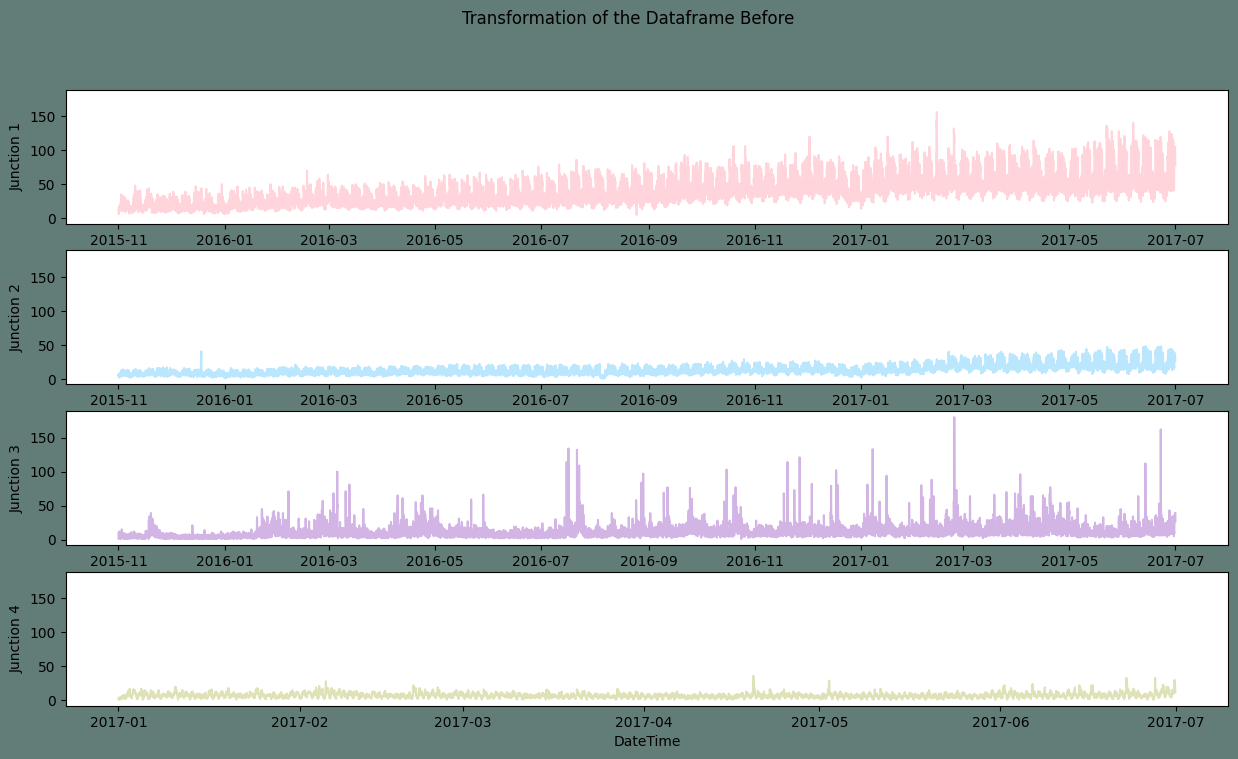

In [11]:
# Creating new dataframes
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.

# As DFS's data frame contains many indices, its index is lowering level one.
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

# Creates comparison dataframe charts using this function
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


# It is displayed to test for stationarity.
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")

In [12]:
# Normalize Function
def Normalize(dataframe,column):
    average = dataframe[column].mean()
    stdev = dataframe[column].std()
    df_normalized = (dataframe[column] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(dataframe,column, interval):
    diff = []
    for i in range(interval, len(dataframe)):
        value = dataframe[column][i] - dataframe[column][i - interval]
        diff.append(value)
    return diff


In [13]:
# In order to make the series stationary, normalize and differ
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference
dataframe_N1 = dataframe_N1[24*7:]
dataframe_N1.columns = ["Norm"]
dataframe_N1["Diff"]= Diff_1

dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference
dataframe_N2 = dataframe_N2[24:]
dataframe_N2.columns = ["Norm"]
dataframe_N2["Diff"]= Diff_2

dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N3 = dataframe_N3[1:]
dataframe_N3.columns = ["Norm"]
dataframe_N3["Diff"]= Diff_3

dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N4 = dataframe_N4[1:]
dataframe_N4.columns = ["Norm"]
dataframe_N4["Diff"]= Diff_4


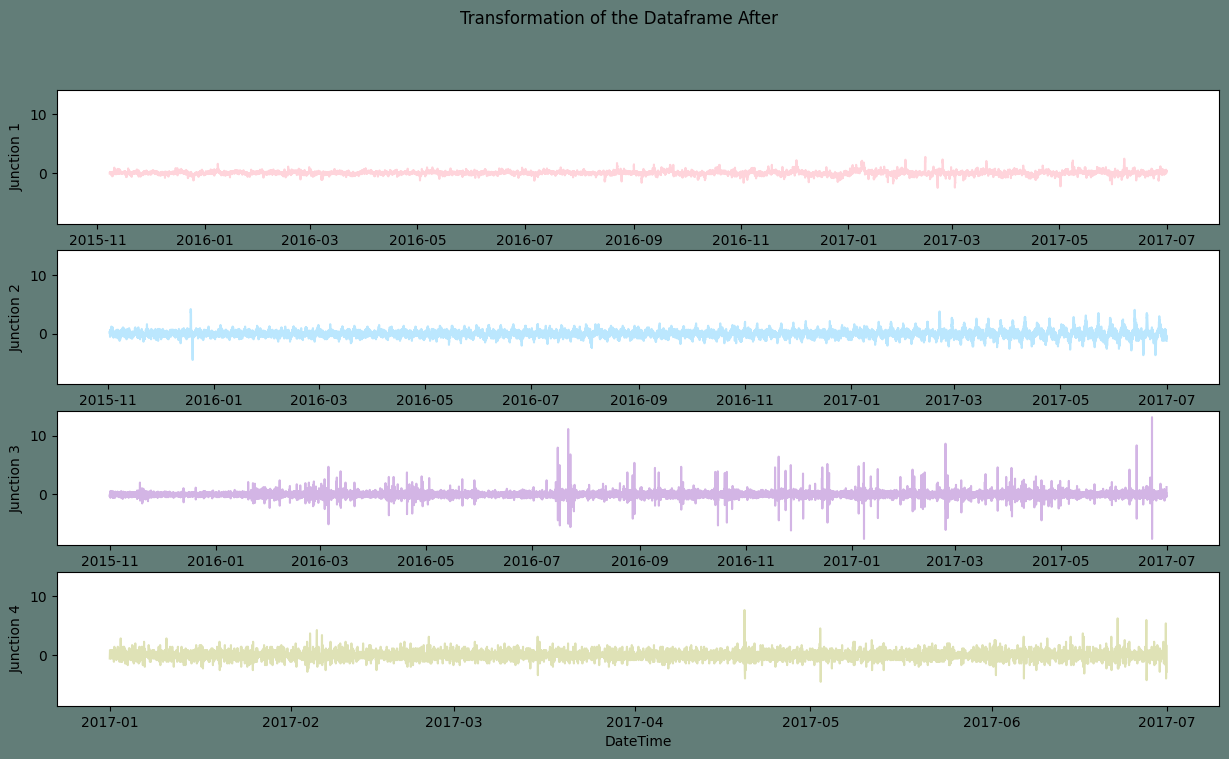

In [14]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")

In [15]:
# Several NA values were produced as a result of differencing using a week's worth of data.
dataframe_J1 = dataframe_N1["Diff"].dropna()
dataframe_J1 = dataframe_J1.to_frame()

dataframe_J2 = dataframe_N2["Diff"].dropna()
dataframe_J2 = dataframe_J2.to_frame()

dataframe_J3 = dataframe_N3["Diff"].dropna()
dataframe_J3 = dataframe_J3.to_frame()

dataframe_J4 = dataframe_N4["Diff"].dropna()
dataframe_J4 = dataframe_J4.to_frame()

# Splitting the dataset
def Split_data(dataframe):
    training_size = int(len(dataframe)*0.90)
    data_len = len(dataframe)
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
# Splitting the training and test datasets
Junction1_train, Junction1_test = Split_data(dataframe_J1)
Junction2_train, Junction2_test = Split_data(dataframe_J2)
Junction3_train, Junction3_test = Split_data(dataframe_J3)
Junction4_train, Junction4_test = Split_data(dataframe_J4)

# Target and Feature
def target_and_feature(dataframe):
    end_len = len(dataframe)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(dataframe[i - steps:i, 0])
        y.append(dataframe[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

# fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

# Assigning features and target
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)

X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)

X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)

X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)


In [17]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# To determine the root mean squared prediction error
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

# Plotting the goal and forecast comparison plot
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()


In [18]:
#Predictions For First Junction
PredJ1 = GRU_model(X_train_Junction1,y_train_Junction1,X_test_Junction1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 433ms/step - loss: 0.0867
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - loss: 0.0662
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 433ms/step - loss: 0.0632
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 408ms/step - loss: 0.0668
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - loss: 0.0614
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 414ms/step - loss: 0.0621
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0604
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 443ms/step - loss: 0.0588
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - loss: 0.0580
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - loss: 0.0568
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 412ms/step - loss: 0.0585
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 0.0581
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - loss: 0.0547
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 433ms/step - loss: 0.0566
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 

The root mean squared error is 0.24608538100829802.


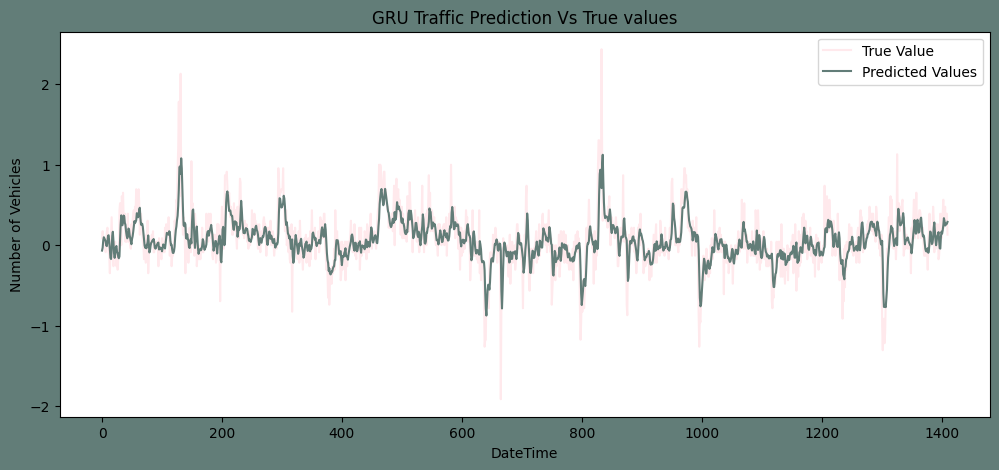

In [19]:
RMSE_J1=RMSE_Value(y_test_Junction1,PredJ1)
PredictionsPlot(y_test_Junction1,PredJ1,0)

In [20]:
print(X_train_Junction2.shape)
print(y_test_Junction1.shape)


(13079, 32, 1)
(1411,)


In [21]:
X_train_Junction2 = X_train_Junction2[:1411]


In [22]:
# Check the sizes of your input and output
print("X_train_Junction2 shape:", X_train_Junction2.shape)
print("y_test_Junction1 shape:", y_test_Junction1.shape)

# If necessary, slice the data to ensure they have the same number of samples
if X_train_Junction2.shape[0] > y_test_Junction1.shape[0]:
    X_train_Junction2 = X_train_Junction2[:y_test_Junction1.shape[0]]
elif y_test_Junction1.shape[0] > X_train_Junction2.shape[0]:
    y_test_Junction1 = y_test_Junction1[:X_train_Junction2.shape[0]]

# Now fit the model
PredJ2 = GRU_model(X_train_Junction2, y_test_Junction1, X_test_Junction2)


X_train_Junction2 shape: (1411, 32, 1)
y_test_Junction1 shape: (1411,)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - loss: 0.1255
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - loss: 0.1178
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step - loss: 0.1115
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - loss: 0.1183
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 568ms/step - loss: 0.1137
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - loss: 0.1162
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 546ms/step - loss: 0.1243
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - loss: 0.1155
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - loss: 0.1100
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - loss: 0.1125
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - loss: 0.1180
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - loss: 0.1166
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - loss: 0.1170
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step 

The root mean squared error is 0.9334248136922875.


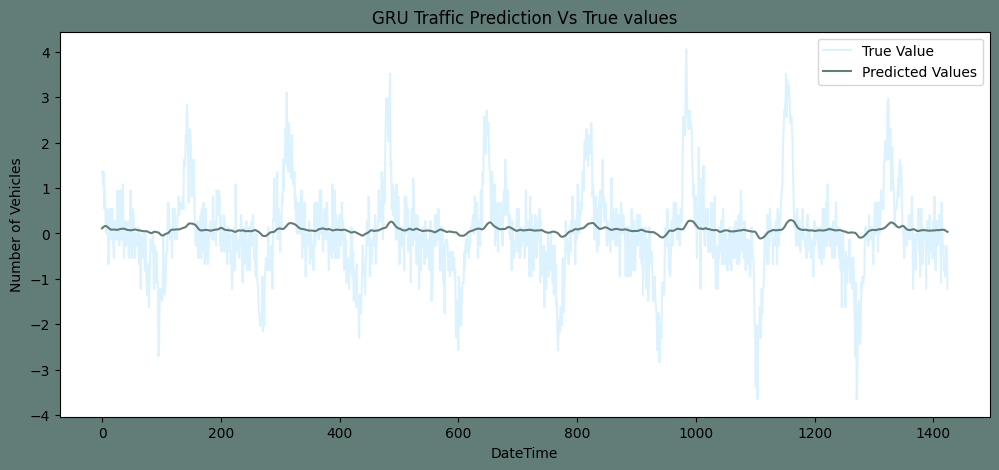

In [23]:
RMSE_J2=RMSE_Value(y_test_Junction2,PredJ2)
PredictionsPlot(y_test_Junction2,PredJ2,1)

In [24]:
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 450ms/step - loss: 0.3132
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - loss: 0.3040
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 428ms/step - loss: 0.3027
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 432ms/step - loss: 0.2873
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 428ms/step - loss: 0.2798
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - loss: 0.3271
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - loss: 0.2931
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 429ms/step - loss: 0.2818
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 427ms/step - loss: 0.2823
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - loss: 0.2841
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 408ms/step - loss: 0.2805
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - loss: 0.2990
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - loss: 0.3027
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step - loss: 0.2779
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 

The root mean squared error is 0.60857302779865.


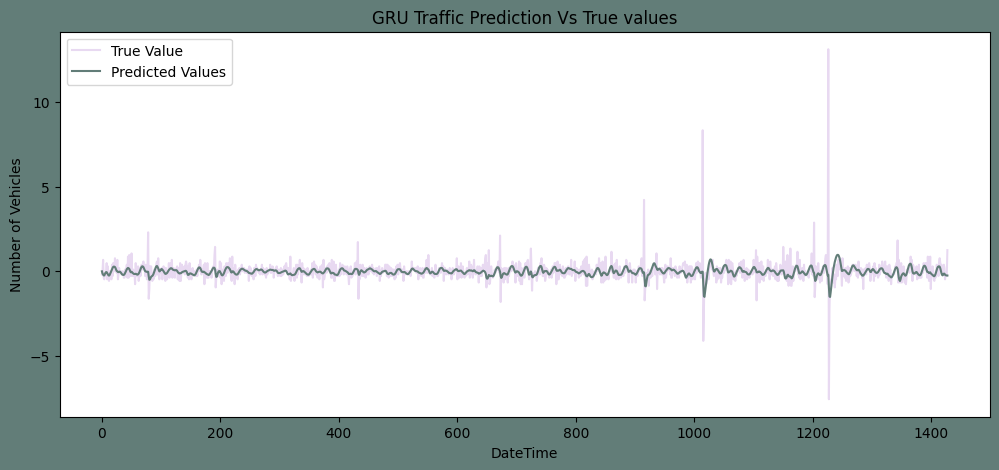

In [25]:
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)
PredictionsPlot(y_test_Junction3,PredJ3,2)

In [27]:
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - loss: 0.6461
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - loss: 0.7044
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - loss: 0.6909
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 445ms/step - loss: 0.6831
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - loss: 0.7161
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - loss: 0.6828
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - loss: 0.6980
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - loss: 0.6618
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - loss: 0.6703
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - loss: 0.6454
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - loss: 0.7256
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - loss: 0.6871
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.6785
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - loss: 0.6887
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 

The root mean squared error is 1.009178716021854.


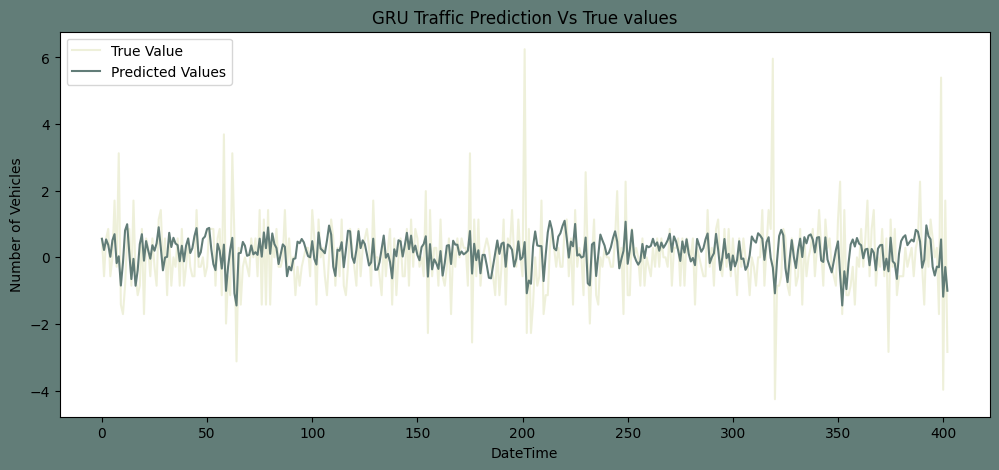

In [28]:
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)
PredictionsPlot(y_test_Junction4,PredJ4,3)


In [29]:
# Set the data in lists to the initial error values of the four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE
0,Junction1,0.246085
1,Junction2,0.933425
2,Junction3,0.608573
3,Junction4,1.009179


In [30]:
# Functions to inverse transforms and plot comparative plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

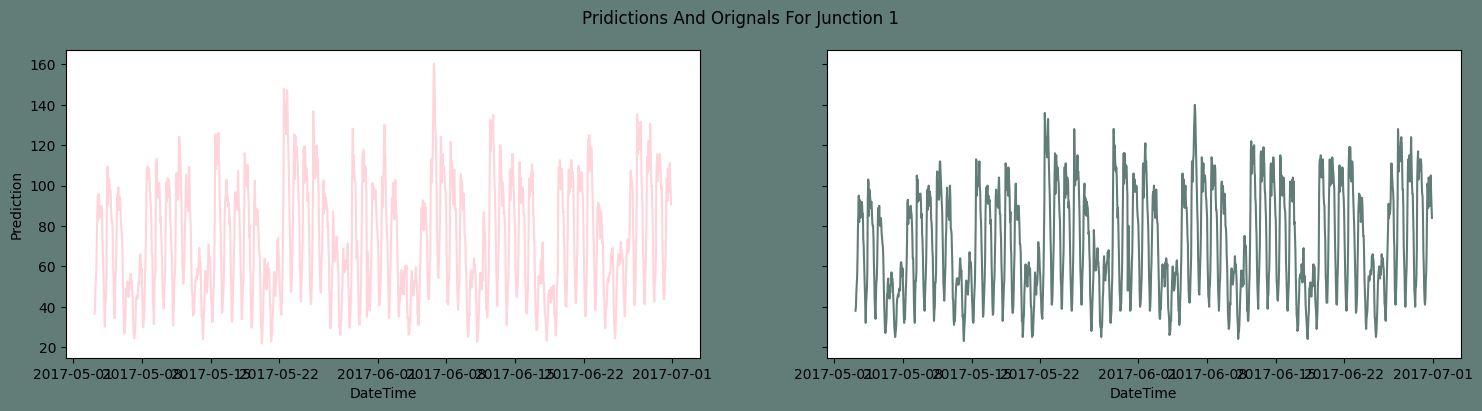

In [31]:
# invert the differenced forecast for Junction 1
recover1 = dataframe_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalization J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + avg_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], dataframe_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

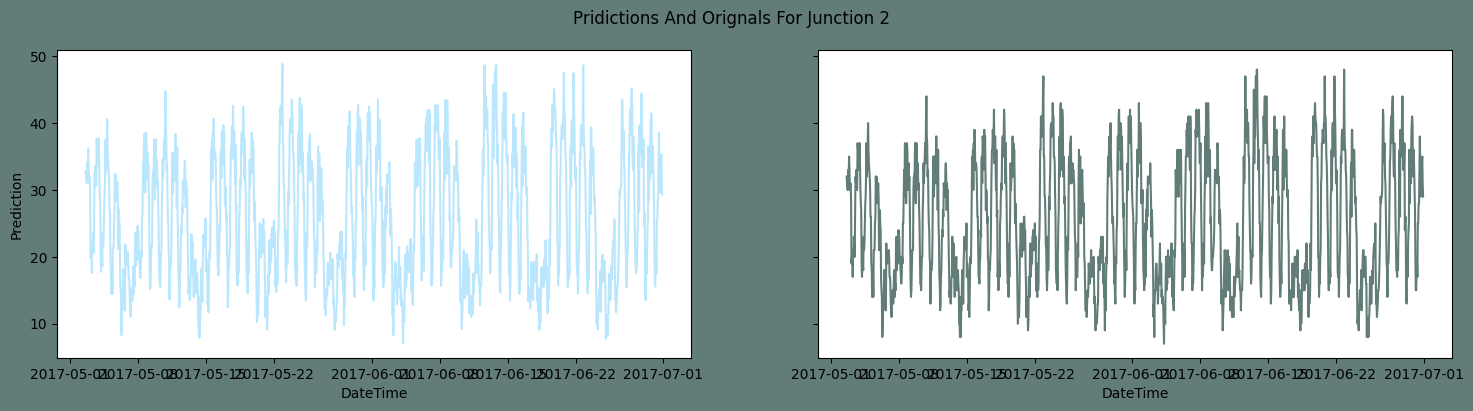

In [32]:
#Invert the differenced J2
recover2 = dataframe_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + avg_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], dataframe_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

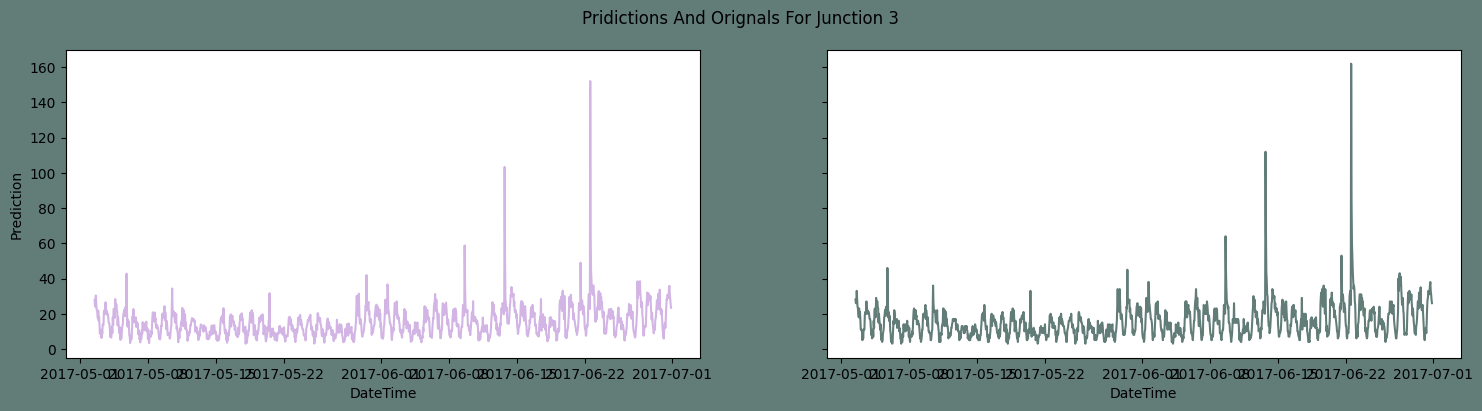

In [33]:
#Invert the differenced J3
recover3 = dataframe_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalization J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + avg_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], dataframe_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

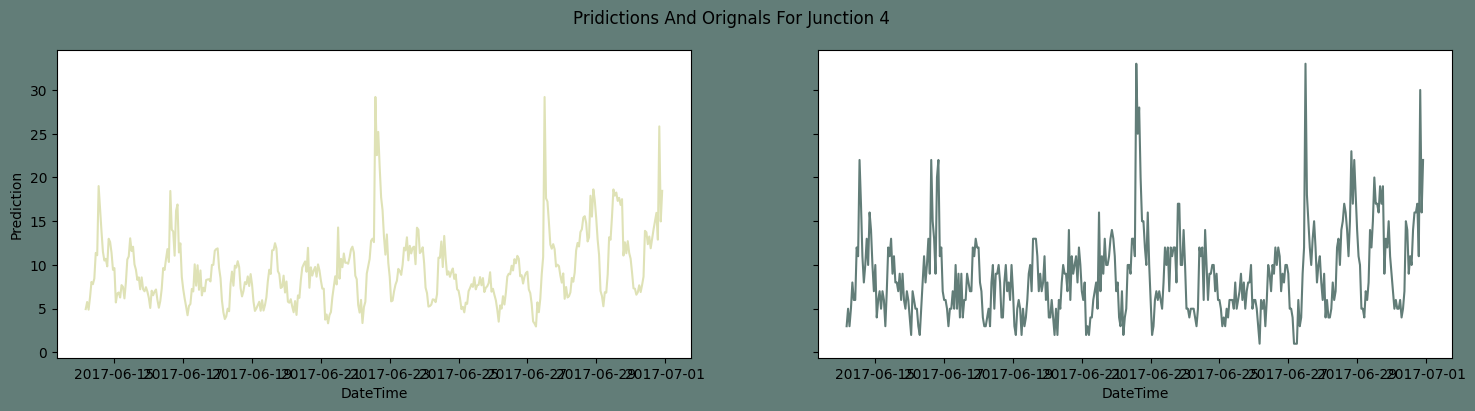

In [34]:
#Invert the differenced J4
recover4 = dataframe_N4.Norm[-404:-1].to_frame()  #len as per the test set
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalization J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + avg_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], dataframe_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

In [36]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130

In [ ]:
import gradio as gr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load the traffic data CSV
data_path = "/content/traffic.csv"
traffic_df = pd.read_csv(data_path)

# Convert DateTime to numeric features (year, month, day, hour, etc.) if needed
traffic_df['Year'] = pd.to_datetime(traffic_df['DateTime']).dt.year
traffic_df['Month'] = pd.to_datetime(traffic_df['DateTime']).dt.month
traffic_df['Day'] = pd.to_datetime(traffic_df['DateTime']).dt.day
traffic_df['Hour'] = pd.to_datetime(traffic_df['DateTime']).dt.hour

# Select features and target variable
features = traffic_df.drop(columns=['Vehicles', 'DateTime', 'ID'])  # Use relevant features only
target = traffic_df['Vehicles']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForest model
model = RandomForestRegressor(n_estimators=10, random_state=0)
model.fit(X_train_scaled, y_train)

# Define function to predict traffic volume for selected junction and date
def predict_traffic(junction, date):
    try:
        # Convert the date to required numeric features
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        date_features = {
            'Year': date_obj.year,
            'Month': date_obj.month,
            'Day': date_obj.day,
            'Hour': 12  # Assuming a fixed hour for simplicity, modify as needed
        }

        # Create input data for the model
        junction_data = pd.DataFrame([{**date_features, 'Junction': junction}])
        junction_data_scaled = scaler.transform(junction_data)

        # Predict traffic volume
        traffic_prediction = model.predict(junction_data_scaled)[0]

        # Return the predicted traffic volume
        return f"Predicted Traffic Volume for {junction} on {date}: {traffic_prediction:.2f}"

    except ValueError:
        return "Please enter the date in YYYY-MM-DD format."

# Gradio interface
junctions_list = traffic_df['Junction'].unique().tolist()

iface = gr.Interface(
    fn=predict_traffic,
    inputs=[
        gr.Dropdown(choices=junctions_list, label="Select Junction"),
        gr.Textbox(label="Enter Date (YYYY-MM-DD)")
    ],
    outputs="text"
)

iface.launch(share=True)
